<a href="https://colab.research.google.com/github/freyakgray/TwinPrimes/blob/GPUnotebook/TwinPrimesGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twin Primes GPU

This is an analytical tool for gathering data about "hexas" that will be used to prove the twin primes conjecture.
This implementation utilizes Numba for CUDA GPU's to write GPU kernels to improve the performance of the tool.
<br/>Contributors: Robbie Jordan, Freya Gray, Lucas Nieddu, Cory Gamble
<br/>[Project repository](https://github.com/freyakgray/TwinPrimes)

In [1]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/lib/python3.7/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-11.0/nvvm/libdevice
find: ‘/proc/30/task/30/net’: Invalid argument
find: ‘/proc/30/net’: Invalid argument
/usr/local/cuda-11.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-11.0/nvvm/lib64/libnvvm.so
find: ‘/proc/30/task/30/net’: Invalid argument
find: ‘/proc/30/net’: Invalid argument


In [2]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [3]:
import numpy as np
from numba import njit, cuda
from numpy.lib import math
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
stream = cuda.stream()

## Generate Hexas

In [6]:
@cuda.jit
def GenerateHexasGPU(hexaArray: np.array):
    """
    Generates hexas, sextands and square sextands using a GPU

    Parameters: 
    hexaArray (numpy array): an empty numpy array where the hexas, sextands and square sextands will be populated. 
    Size of the array will determine the number of hexas, sextands and square sextands generated. 
    The array must be sent to the host with cuda.to_device.
    """
    x,y = cuda.grid(2)
    if(x < hexaArray.shape[0] and y < hexaArray.shape[1]):
        if(x == 0 ):
            hexaArray[0,y] = 3*(y + 1) + (3/2) - ((-1)**(y + 1) * (1/2))
        if(x == 1):
            hexaArray[1,y] = ((1/2) * (y+1)) + (1/4) + ((1/4) * (-1)**((y+1) - 1))
        if(x == 2):
            currentSextand = ((1/2) * (y+1)) + (1/4) + ((1/4) * (-1)**((y+1) - 1))
            if (y % 2 == 0):
                hexaArray[2,y] = 6*(currentSextand**2) - 2*currentSextand
            else:
                hexaArray[2,y] = 6*(currentSextand**2) + 2*currentSextand

def RunGenerateHexasGPU(hexas: int):
    """
    Runs GenerateHexasGPU kernel. Initializes array, sends it to the GPU, runs the kernel and returns the array to the host.
    
    Parameters: 
    hexas (int): the number of hexas to generate

    Returns:
    hexaArray (numpy array): an array of hexas, sextands and square sextands of size hexas
    """
    hexaArray = np.empty([3,hexas], dtype = np.uint64)

    deviceHexa = cuda.to_device(hexaArray, stream = stream)

    threadsPerBlock = (16,16)
    blocksPerGridX = math.ceil(3 / threadsPerBlock[0])
    blocksPerGridY = math.ceil(hexas / threadsPerBlock[1])
    blocksPerGrid = (blocksPerGridX,blocksPerGridY)
    GenerateHexasGPU[blocksPerGrid, threadsPerBlock](deviceHexa)
    hexaArray = deviceHexa.copy_to_host(stream = stream)
    
    return hexaArray

In [7]:
hexaArray = RunGenerateHexasGPU(10000)

print(hexaArray)

/usr/local/lib/python3.7/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda-10.0/nvvm/libdevice.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


[[        5         7        11 ...     29995     29999     30001]
 [        1         1         2 ...      4999      5000      5000]
 [        4         8        20 ... 149950004 149990000 150010000]]


In [8]:
@cuda.jit
def GenerateCombosGPU(hexasChecked: int, length: int, hexaArray: np.array, comboArray: np.array):
    """
    Generates combos of length hexasChecked and checks for validity. First column is the index.
    Last column indicates validity, 0 for invalid, 1 for valid.
    
    Parameters: 
    hexasChecked (int): The number of hexas checked must be less than the number of hexas generated)
    length (int): the number of indices to check combo validity
    hexaArray (numpy array): An array of hexas, sextands and square sextands
    comboArray (numpy array): A 2d array that the function will alter with the index, combo and validity
    """
    x,y = cuda.grid(2)  
    if(x < length and y < hexasChecked):
      if(y == 0):
        comboArray[x,0] = x
      if(x == 0):
          comboArray[0,-1] = 0
      if(y!= 0 or y!= (hexasChecked + 2)):
        comboArray[x, (y + 1)] = (x % hexaArray[0,y])
        if((x % hexaArray[0,y] == hexaArray[1,y] or (x % hexaArray[0,y] == hexaArray[0,y] - hexaArray[1,y])) and x != hexaArray[1,y]):
            comboArray[x,-1] = 0

def RunGenerateCombosGPU(hexasChecked: int, length: int, hexaArray: np.array):
    """
    Runs GeneratesCombosGPU kernel. Initializes arrays, sends them to the GPU, runs the kernel and returns the arrays to the host.
    
    Parameters:
    hexasChecked (int): The number of hexas checked (must be less than the number of hexas generated)
    length (int): The number of indices to check
    hexaArray (numpy array): An array of hexas, sextands and square sextands
    
    Returns: 
    combosArray (numpy array): A 2d array of combos and their validity 
    """
    comboArray = np.zeros([length, (hexasChecked + 2)],dtype = np.uint64)
    comboArray[:,-1] = 1
    
    deviceCombo = cuda.to_device(comboArray, stream = stream)
    deviceHexa = cuda.to_device(hexaArray, stream = stream)

    threadsPerBlock = (32,32)
    blocksPerGridX = math.ceil(length / threadsPerBlock[0])
    blocksPerGridY = math.ceil(hexasChecked / threadsPerBlock[1])
    blocksPerGrid = (blocksPerGridX,blocksPerGridY)
    GenerateCombosGPU[blocksPerGrid, threadsPerBlock](hexasChecked, length, deviceHexa, deviceCombo)

    comboArray = deviceCombo.copy_to_host(stream = stream)
    return comboArray

## Generate Combo Array

In [9]:
comboArray = RunGenerateCombosGPU(100, 1000000, hexaArray)

print(comboArray)

[[     0      0      0 ...      0      0      0]
 [     1      1      1 ...      1      1      1]
 [     2      2      2 ...      2      2      1]
 ...
 [999997      2      5 ...    141     75      0]
 [999998      3      6 ...    142     76      0]
 [999999      4      0 ...    143     77      0]]


## Find Invalid Chains

In [10]:
def FindInvalidChainsGPU(hexasChecked: int, hexaArray: np.array):
    """
    Determines the longest chain of consecutive invalid indices. Must pass in an array generated with GenerateComboArray
    
    Parameters: 
    hexasChecked (int): The number of hexas to be checked
    hexaArray (numpyArray): An array of hexas, sextands and square sextands

    Returns: 
    invalidStart (int): start of the longest invalid chain
    maxInvalid (int): the length of the longest invalid chain
    criticalZoneSize (int): the size of the critical area
    """
    invalidStart = 0
    invalidLength = 0
    maxInvalid = 0
    hexorial = 1
    
    for i in range(hexasChecked):
        hexorial *= hexaArray[0,i]
    hexorial = int((hexorial - 1)/2)

    comboArray = RunGenerateCombosGPU(hexasChecked,hexorial,hexaArray)

    for i in range(hexorial):
        if(comboArray[i,-1] == 0):
            invalidLength += 1
            if(maxInvalid < invalidLength):
                maxInvalid = invalidLength
                invalidStart = i + 1 - maxInvalid
        else:
            invalidLength = 0

    criticalZoneSize = (hexaArray[2,hexasChecked - 1] - hexaArray[2,hexasChecked - 2])
    return invalidStart, maxInvalid, criticalZoneSize

In [11]:
invalidStart, maxInvalid, criticalZoneSize = FindInvalidChainsGPU(5, hexaArray)

print(invalidStart)
print(maxInvalid)
print(criticalZoneSize)

118
17
20


## View Critical Combos

In [12]:
def ViewCritCombosGPU(hexasChecked: int, comboArray: np.array):
    """
    Slices an array generated with GenerateComboArray to contain the combos of the critical area.

    Parameters: 
    hexasChecked (int): The number of hexas to be checked
    comboArray (numpy array): An array of combos generated with GenerateComboGPU. Array must have 
    more indices than the critical area.  
   
    RETURNS:
    critCombosArray (numpy array): An array of combos in the critical area
    """
    sextand = int(((1/2) * (hexasChecked)) + (1/4) + ((1/4) * (-1)**((hexasChecked) - 1)))
    if((hexasChecked - 1) % 2 == 0):
        endPoint = 6*(sextand**2) - 2*sextand
    else:
        endPoint = 6*(sextand**2) + 2*sextand
    critCombosArray = comboArray[:endPoint+1,:]
    return critCombosArray

In [13]:
critCombosArray = ViewCritCombosGPU(6, comboArray)

print(critCombosArray)

[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  1]
 ...
 [58  3  2 ... 58 58  1]
 [59  4  3 ... 59 59  0]
 [60  0  4 ... 60 60  0]]


## Find Average Gap

In [14]:
def FindAverageGapGPU(hexasChecked: int, hexaArray: np.array):
    """
    Calculates the hexorial, lexorial and gap of a hexasChecked amount of hexas.
    
    Parameters: 
    hexasChecked (int): The number of hexas to be checked
    hexaArray (numpy array): An array of hexas, generated with GenerateHexasGPU 
    
    Returns:
    num (int): Hexorial of n hexas
    denom (int): Lexorial of n hexas
    gap (float): average of hexorial/lexorial
    """
    num, denom = 1,1
    for i in range(hexasChecked):
        num *= int(hexaArray[0,i])
        denom *= int(hexaArray[0,i])-2
    gap = num/denom
    return num, denom, gap

In [15]:
num, denom, gap = FindAverageGapGPU(10, hexaArray)

print(num)
print(denom)
print(gap)

835668708875
143210719575
5.835238530711782


## Valid Coordinates

In [16]:
def ValidCoordinatesGPU(comboArray: np.array, hexaArray: np.array):
    """
    Calculates coordinates where x is the number of hexas checked and y is the number of valid combos in critical area.

    Parameters:
    comboArray (numpy array): An array of combos generated with GenerateComboGPU. Array must have 
    more indices than the critical area. 
    hexaArray (numpy array): An array of hexas, sextands and square sextands generated with GenerateHexasGPU.

    Returns: 
    coordinatesArray (numpy array): An array of coordinates where the first column is the number of hexas checked 
    and the second column is the number of valid combos in critical area
    """
    coordinatesArray = np.zeros([(comboArray.shape[1] - 3),2],dtype = int)

    for i in range(2, comboArray.shape[1] - 1):
        coordinatesArray[i-2,0] = i
        validNum = 0
        for j in range(int(hexaArray[2,i-2]), int(hexaArray[2, i-1])):
            if(comboArray[j,-1] == 1):
                validNum += 1
        coordinatesArray[i-2,1] = validNum
    return coordinatesArray

In [17]:
coordinatesArray = ValidCoordinatesGPU(comboArray, hexaArray)

In [18]:
def plotCoordinates(coordinatesArray: np.array):
  """ 
  Plots valid coordinates 
  Parameters: 
  coordinatesArray (numpy array): An array of coordinates where the first column is the number of hexas checked 
  and the second column is the number of valid combos in critical area generated with ValidCoordinatesGPU

  Returns:
  plot: A plot of valid coordinates
  """
  x = coordinatesArray[:,:1]
  y = coordinatesArray[:,-1:]
  plot = plt.plot(x,y)
  return plot


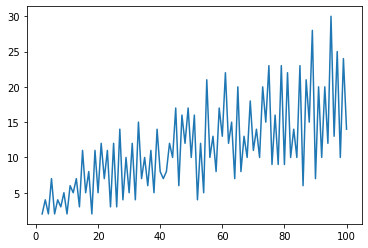

In [20]:
plot = plotCoordinates(coordinatesArray)

## Valid Number Approximation

In [21]:
def ValidNumApproximationGPU(hexasChecked: int, hexaArray: np.array, comboArray: np.array):
    """
    Calculates the expected number of valid combos within the domain (i.e. [1, A] where A is the upper bound of
    the critical area), calculates the actual number of valid combos and calculates the error between the two.
    
    Parameters: 
    hexasChecked (int): The number of hexas to be checked
    hexaArray (numpy array): An array of hexas, sextands and square sextands generated with GenerateHexasGPU
    comboArray (numpy array): An array of combos generated with GenerateCombosGPU. The array must have been generated with at least hexasChecked of hexas.

    Returns: 
    comboApproximation (float): The expected number of valid combos
    comboTrue (int): The actual number of valid combos
    errorPercent (int): The error between comboApproximation and comboTrue
    """
    endPoint = int(hexaArray[2,hexasChecked - 1])
    
    comboApproximation = 1
    for i in range(hexasChecked):
        comboApproximation *= (float(hexaArray[0,i]-2))/(float(hexaArray[0,i]))
    comboApproximation *= endPoint

    comboTrue = np.count_nonzero(comboArray[1:endPoint,-1:])
    error = abs(comboTrue - comboApproximation)/comboTrue
    errorPercent = error * 100
    return comboApproximation, comboTrue, errorPercent

In [22]:
comboApproximation, comboTrue, errorPercent = ValidNumApproximationGPU(25,hexaArray,comboArray)

print(comboApproximation)
print(comboTrue)
print(errorPercent)

94.34918537940382
142
33.556911704645195


## View Critical Area

In [23]:
def ViewCritAreaGPU(hexaArray):
    """
    Calculates the start and end indices of the critical area
    
    Parameters:
    hexaArray (numpy array): An array of hexas, sextands and square sextands generated with GenerateHexasGPU

    Returns:
    start (int): start of the critical area
    end (int): end of the critical area
    """
    length = hexaArray.shape[1]
    start = hexaArray[2,length - 2]
    end = hexaArray[2,length - 1]
    return start, end

In [24]:
start, end = ViewCritAreaGPU(hexaArray)

print(start)
print(end)

149990000
150010000
